# 1 Basic modules

In [6]:
import numpy as np

class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:
        output = module.forward(input)
    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.
        gradInput = module.backward(input, gradOutput)
    """
    def __init__(self):
        self.output = None
        self.grad_input = None
        self.training = True

    def forward(self, inp):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.update_output(inp)

    def backward(self, inp, grad_output):
        """
        Performs a backpropagation step through the module, with respect to the given input.
        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        #print('mod', inp, grad_output)
        self.update_grad_input(inp, grad_output)
        self.acc_grad_parameters(inp, grad_output)
        return self.grad_input

    def update_output(self, inp):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.
        Make sure to both store the data in `output` field and return it.
        """
        # The easiest case:
        # self.output = input
        # return self.output
        pass

    def update_grad_input(self, inp, grad_output):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.
        The shape of `gradInput` is always the same as the shape of `input`.
        Make sure to both store the gradients in `gradInput` field and return it.
        """
        # The easiest case:
        # self.gradInput = gradOutput
        # return self.gradInput
        pass
    
    def acc_grad_parameters(self, inp, grad_output):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zero_grad_parameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def get_parameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def get_grad_parameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.
         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__(self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def update_output(self, inp):
        """
        Basic workflow of FORWARD PASS:
            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})
        Just write a little loop.
        """
        self.output = inp
        for module in self.modules:
            self.output = module.forward(self.output)
            #print(self.output)
        return self.output

    def backward(self, inp, grad_output):
        """
        Workflow of BACKWARD PASS:
            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)
        !!!
        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.
        !!!
        """
        for i in range(len(self.modules) - 1, 0, -1):
            print(i)
            print('seq', self.modules[i - 1].output, grad_output)
            grad_output = self.modules[i].backward(self.modules[i - 1].output, grad_output)
        self.grad_input = self.modules[0].backward(inp, grad_output)
        return self.grad_input

    def zero_grad_parameters(self):
        for module in self.modules:
            module.zero_grad_parameters
    
    def get_grad_parameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.get_grad_parameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

class Criterion(object):
    def __init__(self):
        self.output = None
        self.grad_input = None

    def forward(self, inp, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.
            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.update_output(inp, target)

    def backward(self, inp, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.
            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.update_grad_input(inp, target)

    def update_output(self, inp, output):
        """
        Function to override.
        """
        return self.output

    def update_grad_input(self, input, target):
        """
        Function to override.
        """
        return self.grad_input

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

# Layers
## 1. Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_in`**
- output  **`batch_size x n_out`**

In [7]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
        
        stdv = 1/np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = (n_out))
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def update_output(self, inp):
        print(inp, self.W, self.b)
        self.output = inp@self.W.T + self.b
        return self.output
    
    def update_grad_input(self, inp, grad_output):
        print('grad',inp, grad_output)
        print(grad_output.shape, self.W.shape)
        self.grad_input = grad_output@self.W
        return self.grad_input
    
    def acc_grad_parameters(self, inp, grad_output):
        #self.gradW = np.sum(inp[:, None, :] * grad_output[:, :, None], axis=0)
        #self.gradb = np.sum(grad_output, axis=0)
        self.gradW = np.dot(grad_output.T, inp)
        self.gradb = np.sum(grad_output, axis=0)
        
    def zero_grad_parameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def get_parameters(self):
        return [self.W, self.b]
    
    def get_grad_parameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        return f"Linear {self.W.shape[0]} -> {self.W.shape[1]}"

## 2. SOFTMAX
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

[Notes on softmax](https://deepnotes.io/softmax-crossentropy)

In [8]:
#simple einsum example:
p = np.arange(9).reshape((3, 3))
print(p)
np.einsum('bi,bj->bij', p, p)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


array([[[ 0,  0,  0],
        [ 0,  1,  2],
        [ 0,  2,  4]],

       [[ 9, 12, 15],
        [12, 16, 20],
        [15, 20, 25]],

       [[36, 42, 48],
        [42, 49, 56],
        [48, 56, 64]]])

In [9]:
def softmax(inp):
    return np.exp(inp) / np.sum(np.exp(inp), axis=0)

In [10]:
class SoftMax(Module):
    def __init__(self):
        super(SoftMax, self).__init__()
        
    
    def update_output(self, inp):
        # start with normalization for numerical stability
        self.output = np.subtract(inp, inp.max(axis=1, keepdims=True))
        # Your code goes here. ################################################
        self.output = np.exp(self.output)/np.sum(np.exp(self.output), axis=1, keepdims=True)
        return self.output
    
    def update_grad_output(self, inp, grad_output):
        ################################################
        # First we create for each example feature vector, it's outer product with itself
        # ( p1^2  p1*p2  p1*p3 .... )
        # ( p2*p1 p2^2   p2*p3 .... )
        # ( ...                     )
        #  
        # Second we need to create an (n_feats, n_feats) identity of the feature vector
        # ( p1  0  0  ...  )
        # ( 0   p2 0  ...  )
        # ( ...            )
        # 
        # Then we need to subtract the first tensor from the second
        # ( p1 - p1^2   -p1*p2   -p1*p3  ... )
        # ( -p1*p2     p2 - p2^2   -p2*p3 ...)
        # ( ...                              )
        # 
        ################################################\
        pred_grad = np.multiply(self.output, gradOutput)
        self.grad_input = pred_grad - np.multiply(self.output, np.sum(pred_grad, axis=1, keepdims=True))
        return self.grad_input

    def __repr__(self):
        return "SoftMax"

# Activation Layers

In [11]:
class LeakyReLU(Module):
    
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
        self.slope = slope
        
    def update_output(self, inp):
        self.output = inp.copy()
        mask = inp < 0
        self.output[mask] *= self.slope
        return self.output
    
    def update_grad_input(self, inp, grad_output):
        self.grad_input = grad_output.copy()
        mask = inp < 0
        self.grad_input[mask] *= self.slope
        return self.grad_input
    
    def __repr__(self):
        return "LeakyReLU"

# Criterions

# 1 MSE

In [12]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def update_output(self, inp, target):   
        self.output = np.sum(np.power(inp - target,2)) / inp.shape[0]
        return self.output 
 
    def update_grad_input(self, inp, target):
        self.grad_input  = (inp - target) * 2 / inp.shape[0]
        return self.grad_input

    def __repr__(self):
        return "MSECriterion"

# NLL

In [13]:
a = np.array(([1, 2, 5], [1, 2, 3], [5, 1, 3]))
b = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])
a[np.arange(3), np.argmax(b, axis=1)]

array([2, 1, 3])

In [14]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def update_output(self, inp, target): 
        
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(inp, self.EPS, 1 - self.EPS) 
        
        self.output = - np.sum(np.multiply(target, np.log(input_clamp)))/inp.shape[0]
        return self.output

    def update_grad_input(self, inp, target):
        
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(inp, self.EPS, 1 - self.EPS)
        self.grad_input = - (target / input_clamp)/inp.shape[0]
        return self.grad_input
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

# OPTIMIZERS

In [15]:
def sgd_momentum(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            old_grad = state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))
            
            np.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad, out=old_grad)
            
            current_var -= old_grad
            var_index += 1     

In [ ]:
import matplotlib.pyplot as plt
#Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

In [1]:
net = Sequential()
net.add(Linear(2, 2))

net.add(LeakyReLU())
criterion = ClassNLLCriterionUnstable()

print(net)

NameError: name 'Sequential' is not defined

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [ ]:
from IPython.display import clear_output

loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zero_grad_parameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        print(loss)
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.get_parameters(), 
                   net.get_grad_parameters(), 
                   optimizer_config,
                   optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)   

# Pytorch

In [118]:
from torch import nn
from torch import from_numpy
from torch import sigmoid
import torch.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler

In [125]:
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
    X = MinMaxScaler().fit_transform(X)  
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
        
        out_X = torch.autograd.Variable(from_numpy((X[batch_idx])))
        out_y = from_numpy(np.argmax(Y[batch_idx], axis=1))
        #print(out_X)
        yield out_X, out_y

In [126]:
%matplotlib inline
#Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
#plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

In [140]:
class LogRegClass(nn.Module):
    def __init__(self):
        super(LogRegClass, self).__init__()
        self.lin1 = nn.Linear(2, 2, dtype=torch.float64)
    
    def forward(self, x):
        out = self.lin1(x)
        #out = sigmoid(x)
        return out

In [141]:
net = LogRegClass()

In [142]:
opt = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.NLLLoss()

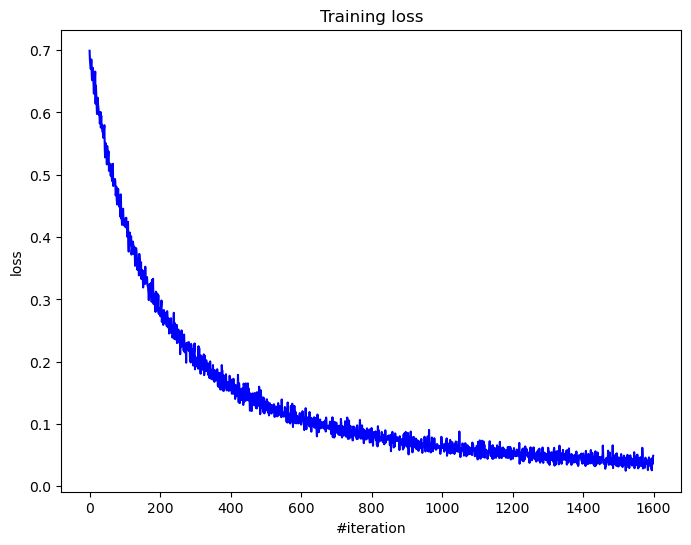

Current loss: 0.048989


In [143]:
loss_history = []
n_epoch = 200
batch_size = 128
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        opt.zero_grad()

        outputs = net(x_batch)
        
        #print(outputs, y_batch)
        compute_loss = criteria(outputs, y_batch)

        compute_loss.backward()

        opt.step()
        loss_history.append(compute_loss.detach().numpy())
    # Visualize
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % compute_loss)   

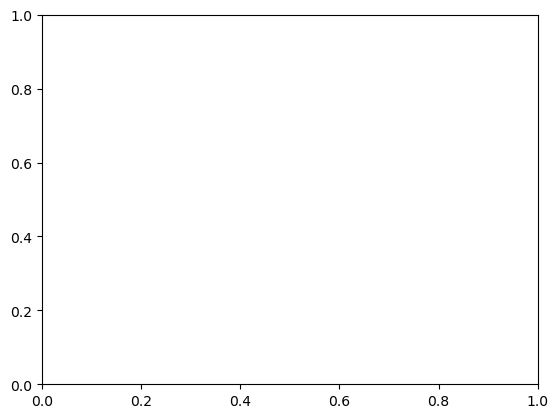

In [8]:
fig, ax = plt.subplots(1, 1)

In [103]:
class LogisticRegression_class(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(LogisticRegression_class, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):

        outputs = self.linear(x)

        return outputs

In [104]:
batch_size = 100

n_iters = 3000

epochs = n_iters / (len(mnist_train) / batch_size)

input_dim = 784

output_dim = 10

lr_rate = 0.001
logistic_model = LogisticRegression_class(input_dim, output_dim)
criteria = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(logistic_model.parameters(), lr=lr_rate)

In [106]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
iterations = 0
loss_history = []
for epoch in range(int(epochs)):

    for i, (images, labels) in enumerate(mnist_train_loader):

        images = torch.autograd.Variable(images.view(-1, 28 * 28))

        labels = torch.autograd.Variable(labels)

        optim.zero_grad()

        outputs = logistic_model(images)
        print(outputs, labels)
        compute_loss = criteria(outputs, labels)
        
        compute_loss.backward()

        optim.step()

        iterations+=1
        
        loss_history.append(compute_loss.detach().numpy())
        
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

tensor([[ 2.5085e-01, -2.8625e-01, -1.7261e-01, -3.1026e-01,  1.6939e-01,
         -6.2593e-02,  7.9605e-02, -3.0633e-01,  1.0815e-01,  6.2076e-02],
        [-1.2227e-01, -2.1891e-01, -1.6052e-01,  1.2346e-01, -9.6056e-02,
          8.3932e-02, -2.6545e-01, -2.9127e-01,  2.0194e-01, -1.2927e-01],
        [ 7.9883e-02, -5.0503e-02,  2.0690e-01, -4.9580e-01, -1.0365e-01,
         -3.0935e-03,  1.4797e-01, -3.0956e-01, -1.3424e-02, -4.2469e-01],
        [ 2.5773e-01, -7.4306e-02, -1.2930e-01, -7.7467e-02,  1.6842e-01,
          5.7438e-02, -8.1663e-02,  3.1870e-01, -1.4701e-02,  2.6471e-01],
        [ 1.0764e-01, -1.7439e-01, -5.6320e-02, -9.8382e-03,  1.7179e-01,
          3.2833e-01, -7.9420e-02,  2.0062e-01,  1.2325e-01,  2.9362e-01],
        [ 1.9283e-01,  1.3510e-01,  6.0621e-02,  7.9528e-02, -1.4248e-01,
          2.1992e-01,  1.4123e-01,  1.2977e-01,  2.2540e-01, -1.7419e-01],
        [ 1.6276e-01, -2.9022e-01,  2.2400e-01,  6.0694e-02, -2.2788e-02,
          3.5136e-01, -3.5751e-0

tensor([[ 2.2748e-01, -2.6268e-01, -6.0445e-02, -7.8838e-02, -5.0020e-02,
          9.2332e-02, -1.7730e-01,  1.3478e-01, -4.0286e-02, -3.9568e-02],
        [-8.6323e-02,  6.5642e-02,  7.0066e-02,  5.7405e-02, -3.6213e-01,
          3.6876e-01,  1.0529e-01, -2.4871e-01,  4.5097e-01, -4.4961e-01],
        [ 3.0410e-02,  8.3132e-02,  1.3603e-01,  2.6391e-01, -2.4972e-01,
          2.2144e-01, -3.5699e-02, -8.1005e-02,  3.6183e-01, -2.9667e-01],
        [-2.8564e-02,  1.5500e-02, -5.9892e-02,  1.6664e-01,  1.0236e-01,
          2.7604e-01, -2.3722e-02,  2.4402e-01,  2.5909e-01,  4.8307e-02],
        [-1.6473e-01,  1.7430e-01,  1.6561e-01,  1.0356e-01, -1.4769e-01,
          1.1102e-01, -8.4906e-02, -1.2501e-01, -3.4203e-02, -1.4810e-01],
        [ 4.3084e-01, -2.5713e-01, -1.0201e-01, -1.0924e-02,  1.2813e-01,
         -1.1669e-01, -5.4304e-02, -1.8009e-01,  1.9032e-02, -3.2956e-01],
        [-5.7942e-02,  1.5751e-01,  6.4745e-03,  5.8919e-02, -1.5513e-01,
          3.2504e-02, -3.7847e-0

tensor([[-9.4261e-02,  7.8290e-02,  2.6038e-01, -3.7284e-02, -3.9436e-01,
          1.0161e-01,  1.5405e-01, -1.8665e-01,  2.8833e-01, -3.9889e-01],
        [ 4.0523e-01, -2.6724e-01, -2.8408e-01, -1.5919e-01,  4.3425e-02,
          1.3350e-01, -2.5470e-01, -1.0522e-01,  4.1351e-03, -2.4640e-01],
        [-6.0894e-02,  1.1493e-01, -7.5444e-02,  3.6083e-01, -1.4083e-01,
         -1.2224e-01,  2.8113e-03,  5.2896e-03,  1.2630e-01, -1.0196e-01],
        [-1.6703e-01,  5.4217e-02, -1.3498e-01, -6.9706e-02,  1.8946e-01,
         -2.5683e-02, -4.4390e-02, -1.5493e-01,  3.9003e-02,  2.2278e-02],
        [-1.3393e-01,  1.6288e-02, -1.6602e-02, -2.4877e-01, -1.5962e-01,
          4.0035e-01, -1.3181e-01, -3.0711e-01,  3.5127e-01, -1.2994e-01],
        [ 1.2254e-01,  3.7826e-02,  3.5270e-02,  2.7057e-02, -4.3813e-01,
          2.8467e-01,  3.1933e-01, -7.1995e-02,  2.5463e-01, -8.6168e-02],
        [ 2.4625e-01, -1.2104e-01, -6.8102e-02, -2.1544e-01,  8.3292e-02,
         -5.3870e-02, -1.1273e-0

tensor([[ 1.0735e-01,  8.5038e-02,  2.4421e-02,  2.3173e-01, -2.9171e-01,
          5.4481e-02,  6.2916e-02,  3.3246e-02,  2.0661e-03, -1.1001e-01],
        [-2.2793e-01,  3.5807e-01,  2.2905e-01, -1.5670e-02, -2.5141e-01,
          1.8495e-01,  1.4439e-02, -2.6218e-01,  9.6249e-02, -3.0285e-01],
        [-7.5131e-03,  1.4363e-02,  7.5074e-02,  3.0155e-01,  6.0529e-02,
         -1.2491e-01, -8.8043e-03, -1.8749e-01,  2.0484e-01, -1.7849e-01],
        [-2.0725e-01,  1.5691e-01, -6.5746e-02,  8.7588e-02,  2.2957e-01,
          1.3836e-01, -1.2859e-01,  2.1883e-01,  1.8484e-02, -3.1728e-02],
        [ 1.2616e-01, -2.8729e-01, -1.8594e-01, -2.8821e-02,  1.4370e-01,
         -3.2631e-02, -4.1172e-02,  4.0911e-01,  2.6117e-02,  2.6857e-01],
        [-9.7930e-02,  2.9191e-01,  1.4084e-01,  4.0120e-02, -1.0921e-01,
          1.4093e-01, -9.1965e-02,  8.2124e-02, -4.1241e-02, -1.1042e-01],
        [ 4.5332e-01, -2.2224e-01, -9.2716e-02, -1.5630e-01, -1.5640e-01,
         -2.2402e-01,  1.1584e-0

tensor([[ 3.1931e-01, -3.5618e-01, -1.0312e-01, -1.4453e-01,  5.0670e-02,
          4.8132e-02, -1.7705e-01, -2.2300e-01,  1.7478e-01, -1.0866e-01],
        [ 1.3558e-02,  2.3717e-02,  3.9332e-02, -3.1792e-01, -1.9262e-01,
          6.6990e-02,  4.0409e-01, -8.1653e-02,  2.2405e-01, -7.9260e-02],
        [ 7.3371e-03,  7.0402e-02, -9.0411e-02, -3.3145e-02,  1.6828e-01,
          7.7147e-02, -3.4605e-03,  6.2283e-03,  3.4082e-02, -6.1618e-02],
        [ 1.5477e-01, -1.0356e-01, -4.2569e-02, -1.0632e-01,  5.6815e-02,
          2.8924e-01,  1.0792e-02,  2.8315e-02,  1.5136e-01,  2.2075e-01],
        [ 3.8345e-02, -4.0169e-02,  1.5498e-01,  6.2380e-02,  6.6912e-02,
         -6.3185e-02, -1.0997e-01,  3.7661e-01,  1.5013e-01,  1.5081e-01],
        [ 8.3002e-02,  9.0486e-02, -3.3325e-01, -2.3210e-02,  2.7211e-01,
          1.3984e-01,  4.1539e-03, -1.9238e-01, -1.3731e-01, -8.6454e-02],
        [ 9.5188e-02, -4.4505e-02,  1.2751e-01, -6.7545e-02, -3.1848e-01,
         -5.9240e-02,  4.3545e-0

tensor([[-0.0470,  0.0262, -0.0642, -0.0146, -0.0249,  0.0216, -0.1100,  0.2314,
          0.1139,  0.1038],
        [-0.1868,  0.2362,  0.2220,  0.0845, -0.0336,  0.0960,  0.0477, -0.1258,
          0.0520, -0.3376],
        [-0.2022,  0.2035,  0.1726, -0.0535, -0.2758, -0.0847,  0.1077, -0.4068,
          0.4773, -0.5294],
        [-0.0702,  0.1263,  0.1459, -0.0253, -0.1550,  0.0225, -0.1219, -0.1679,
         -0.0381, -0.1017],
        [ 0.3392, -0.2621,  0.1095, -0.1260,  0.0852,  0.3006, -0.0058, -0.0861,
          0.0406, -0.1126],
        [ 0.2209,  0.0845, -0.1127, -0.1392,  0.0695,  0.0115,  0.1937, -0.0653,
          0.0895, -0.1365],
        [ 0.2822, -0.1569, -0.2887,  0.0140,  0.2177,  0.1089, -0.1178,  0.4284,
         -0.0292,  0.2831],
        [-0.0533,  0.2305, -0.0200, -0.0500, -0.2369,  0.2436,  0.0907,  0.0919,
          0.3600, -0.2006],
        [ 0.1215, -0.1484, -0.0135,  0.2369,  0.0435,  0.2256, -0.1889,  0.0593,
          0.1564, -0.0076],
        [ 0.1724, -

tensor([[ 3.5422e-01, -5.6162e-02,  1.1320e-01, -2.1105e-01,  3.0144e-03,
         -2.5469e-02, -1.1858e-01, -3.9494e-01,  1.2407e-01, -3.3659e-01],
        [-1.0598e-02,  3.6588e-02,  1.1542e-01, -8.4875e-02, -2.8778e-02,
          3.0689e-02,  1.8113e-02,  3.6151e-01,  6.9217e-02,  1.4164e-01],
        [-1.5491e-01,  5.4514e-02,  9.3926e-02,  1.1184e-01, -1.2320e-01,
          1.8650e-01, -1.8339e-01,  1.5763e-01,  1.0916e-01,  1.7708e-02],
        [ 2.0029e-01, -1.0504e-01,  7.2454e-02, -1.2628e-02,  2.5513e-01,
          3.0401e-01, -1.1270e-01, -9.1772e-02,  1.2444e-01,  8.7933e-02],
        [ 3.1565e-02, -1.9398e-01,  1.7304e-01,  3.3835e-01, -5.0763e-02,
          4.6156e-01, -7.3938e-02,  1.8911e-01,  2.9792e-01,  2.3980e-01],
        [ 1.4565e-01, -7.2933e-02, -5.7729e-02, -2.3748e-01,  5.5325e-02,
          1.0347e-01, -3.8369e-02,  2.6358e-01, -1.0926e-02,  2.3428e-01],
        [ 1.8941e-01, -1.6997e-02,  1.1999e-01, -1.3494e-01,  8.4232e-02,
          8.7740e-02,  2.5359e-0

tensor([[ 5.7611e-01, -1.9007e-01, -2.3541e-01, -2.9892e-01, -3.5206e-02,
         -2.1473e-02,  1.2282e-01, -1.0693e-01,  2.8601e-01, -5.2680e-01],
        [-1.1498e-01, -2.2456e-01,  1.1877e-01, -4.0204e-02,  4.8962e-02,
          3.9042e-01, -8.5494e-02,  2.2176e-01,  2.7592e-01,  1.1121e-01],
        [-1.4354e-01,  2.7076e-01, -1.1944e-02,  6.9384e-02, -1.6345e-01,
          1.7826e-02, -9.7539e-02,  5.5991e-02, -1.0947e-02, -1.3189e-01],
        [-9.6850e-02,  1.2075e-01,  4.7754e-02, -7.2842e-02, -2.1584e-01,
          4.0010e-01,  1.6183e-01, -3.5992e-02,  3.9824e-01, -3.6369e-01],
        [ 3.7336e-02, -1.8961e-01,  9.2052e-02, -1.1151e-02,  2.2060e-02,
          6.6938e-02,  1.4899e-01,  2.3136e-02,  9.6440e-02, -3.3583e-01],
        [ 3.8123e-02, -1.0636e-02, -1.1030e-01,  2.4805e-01, -4.9052e-02,
         -3.7007e-02, -4.3239e-02, -8.7000e-02,  4.4762e-02, -3.6631e-02],
        [-2.6019e-01,  9.7145e-02,  2.4163e-01,  5.4066e-02, -1.4656e-01,
          2.1213e-01, -1.2764e-0

tensor([[-3.7318e-02,  1.0786e-02, -2.2712e-02, -9.2038e-02, -1.3711e-01,
          1.0759e-01,  3.5303e-01,  3.8544e-02,  2.0071e-01, -3.9059e-01],
        [ 3.2779e-01, -4.0435e-01, -4.0780e-02, -1.3975e-01,  1.5594e-01,
          1.3548e-01, -4.8977e-02, -6.2501e-03,  5.8643e-02, -1.3712e-01],
        [ 3.0529e-01,  7.3508e-03, -4.5975e-01,  5.3121e-02,  3.0474e-01,
         -1.6796e-01, -1.4067e-01, -1.0891e-01, -1.3601e-01,  1.2930e-01],
        [-2.8424e-02,  1.1810e-01, -2.4196e-01, -2.5106e-01, -3.9714e-02,
         -5.4382e-03,  3.1741e-01, -4.3181e-01,  5.2440e-01, -1.5888e-01],
        [ 2.0222e-01, -3.5905e-02, -7.7085e-02, -1.3911e-01,  2.2132e-01,
         -7.8075e-03, -6.6638e-02,  4.0773e-01,  2.1141e-02,  1.7446e-01],
        [ 1.7219e-01, -3.1130e-02,  1.1356e-01, -3.9735e-02, -1.4865e-01,
          2.8226e-01,  1.5827e-02,  3.6781e-02,  3.0040e-01, -1.8115e-01],
        [ 3.3340e-01, -4.4572e-01, -7.7563e-02, -1.6594e-01,  3.4804e-02,
          1.8870e-01, -1.0775e-0

KeyboardInterrupt: 